# Build a 3D self-driving dataset from scratch with OpenAI's Point-E and Fiftyone

In this walkthrough, we will show you how to build your own $3D$ point cloud dataset using OpenAI's [Point-E](https://github.com/openai/point-e) for $3D$ point cloud synthesis, and FiftyOne for dataset curation and visualization.

Specifically, this walkthrough covers:

* Generating $3D$ point clouds from text with Point-E
* Loading point cloud data into FiftyOne
* Curating synthetically generated data assets
* Constructing a high-quality point-cloud dataset for self-driving applications

**So, what's the takeaway?**

FiftyOne can help you to understand, curate, and process $3D$ point cloud data and build high quality $3D$ datasets

![pointe-preview](images/pointe_preview.gif)

## Setup

To get started, you need to install [FiftyOne](https://docs.voxel51.com/getting_started/install.html) and [Point-E](https://github.com/openai/point-e):

To install FiftyOne, you can use the Python package installer `pip`:

In [ ]:
!pip install fiftyone

To install Point-E, you will need to clone the [Point-E github repo](https://github.com/openai/point-e):

In [ ]:
!git clone https://github.com/openai/point-e.git

And then `cd` into the `point-e` directory and install the package locally:

In [ ]:
!pip install -e .

You will also need to have [Open3D](http://www.open3d.org/) and [PyTorch](https://pytorch.org/) installed:

In [ ]:
!pip install open3d torch

Next, we'll import all of the relevant modules that we will be using in this walkthrough:

In [ ]:
import numpy as np
import open3d as o3d
import random
import torch
from tqdm.auto import tqdm
import uuid

In [4]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
import fiftyone.utils.utils3d as fou3d
from fiftyone import ViewField as F

In [18]:
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

We will also set our device:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Generating a point cloud from text

Following the OpenAI's [text2pointcloud](https://github.com/openai/point-e/tree/main/point_e/examples) example notebook, we will show how to generate a $3D$ point cloud with an input text prompt.

For this walkthrough, we will use OpenAI's `base40M-textvec` model, which is a model with $40M$ parameters which takes a text prompt as input and generates an embedding vector.

In [14]:
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval();
base_model.load_state_dict(load_checkpoint(base_name, device));
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

Applied on its own, this model will generate a point cloud with $1024$ points. We will also use an upsampler to generate from this a point cloud with $4096$ points:

In [15]:
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

<All keys matched successfully>

The base diffusion model and upsampling diffusion model are joined together in a `PointCloudSampler` object, which will take in a text prompt, and output a point cloud with $4096$ points:

In [16]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

Let's see this point cloud diffusion model in action, with the text prompt 'a red and white traffic cone':

In [22]:
# Set a prompt to condition on.
prompt = 'a red and white traffic cone'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

We can visualize this with Point-E's native visualizer: 

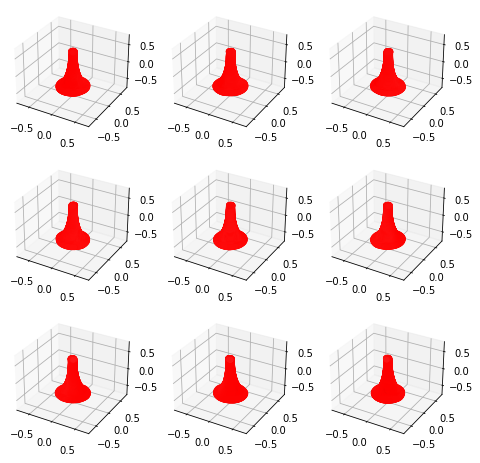

In [23]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

Point-E's diffusion model is probabilistic, so if we were to run the model again, we would get a different result.

## Loading a Point-E point cloud into FiftyOne

It is nice that Point-E provides its own native visualizer, but these two-dimensional projections are inherently limited. We can far more thoroughly and interactively visualize point clouds in FiftyOne's [$3D$ visualizer](https://docs.voxel51.com/user_guide/groups.html#using-the-3d-visualizer). Let's see how to load a Point-E point cloud into FiftyOne:

In order to load the point cloud into FiftyOne, we will convert the point cloud from Point-E's native format into a more standard Open3D format, and create a sample in FiftyOne. First, let's see what the data structure for Point-E point clouds look like:

In [24]:
print(pc)

PointCloud(coords=array([[-0.03309404,  0.02550882,  0.3323171 ],
       [ 0.04414998,  0.00349532,  0.20193087],
       [-0.09602042,  0.01112842, -0.18279059],
       ...,
       [ 0.07348648,  0.06262259, -0.1602327 ],
       [-0.05210277, -0.12158105, -0.28146288],
       [ 0.08027986, -0.12295438, -0.31632814]], dtype=float32), channels={'R': array([0.9960785, 0.9960785, 1.       , ..., 0.9960785, 0.9960785,
       0.9960785], dtype=float32), 'G': array([0.01960784, 0.01568628, 0.02745098, ..., 0.03137255, 0.00392157,
       0.00784314], dtype=float32), 'B': array([0.02352941, 0.01568628, 0.02745098, ..., 0.03137255, 0.00392157,
       0.00784314], dtype=float32)})


Position coordinates are represented by a $(4096, 3)$ array in the `coords` attribute:

In [27]:
print(pc.coords.shape)

(4096, 3)


And point colors are stored in a dict object within `channels`:

In [31]:
print(pc.channels.keys())
print(len(pc.channels['R']))

dict_keys(['R', 'G', 'B'])
4096


We can write a simple function that will take in a text prompt, generate the Point-E point cloud, and convert this into a standard Open3D point cloud (`open3d.geometry.PointCloud`) object:

In [32]:
def generate_pcd_from_text(prompt):
    samples = None
    for x in sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt])):
        samples = x
    pointe_pcd = sampler.output_to_point_clouds(samples)[0]

    channels = pointe_pcd.channels
    r, g, b = channels["R"], channels["G"], channels["B"]
    colors = np.vstack((r, g, b)).T
    points = pointe_pcd.coords

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

To load this Open3D point cloud into FiftyOne, we can use Open3D's `open3d.io` module to write the point cloud to a `.pcd` file, and then create a FiftyOne Sample object associated with this file:

In [ ]:
rubber_duck_pcd = generate_pcd_from_text('a yellow rubber duck')
rubber_duck_file = "rubber_duck.pcd"
o3d.io.write_point_cloud(rubber_duck_file, rubber_duck_pcd)

In [ ]:
rubber_duck_dataset = fo.Dataset(name = "rubber_duck_dataset")
rubber_duck_dataset.add_sample(
    fo.Sample(filepath=rubber_duck_file)
)
session = fo.launch_app(rubber_duck_dataset)

![pointe-rubber_duck](images/pointe_rubber_duck.png)

## Curating synthetic $3D$ point cloud assets

Now that we have a workflow for generating $3D$ point cloud samples in FiftyOne with Point-E, we can generate an entire dataset of synthetic $3D$ point clouds. 

In this walkthrough, we will generate a variety of vehicles. In particular, we will generate point clouds for vehicles of type `car`, `bike`, `bus`, and `motorcycle`. We will specify what vehicle we want Point-E to generate in our text prompt. Due to the probabilistic nature of diffusion models like Point-E, merely running a simple prompt like "a bicycle" multiple times will generate distinct point cloud models. 

To add even more variety, we will instruct Point-E to paint each of the vehicles two randomly chosen colors with a prompt of the form: `"a $(COLOR1) $(VEHICLE_TYPE) with $(COLOR2) wheels"`. This is just an illustrative example.

In [1]:
VEHICLE_TYPES = ["car", "bus", "bike", "motorcycle"]
VEHICLE_COLORS = ["red", "blue", "green", "yellow", "white"]

In this example, we will generate random filenames for each of the point cloud models, but you can specify filenames however you'd like:

In [2]:
def generate_filename():
    rand_str = str(uuid.uuid1()).split('-')[0]
    return "pointe_vehicles/" + rand_str + ".pcd"

In [3]:
def generate_pointe_vehicle_dataset(
    dataset_name = "point-e-vehicles",
    num_samples = 100
):
    samples = []
    for i in tqdm(range(num_samples)):
        vehicle_type = random.choice(VEHICLE_TYPES)
        cols = random.choices(VEHICLE_COLORS, k=2)
        prompt = f"a {cols[0]} {vehicle_type} with {cols[1]} wheels"
        pcd = generate_pcd_from_text(prompt)
        ofile = generate_filename()
        o3d.io.write_point_cloud(ofile, pcd)
        
        sample = fo.Sample(
            filepath = ofile,
            vehicle_type = fo.Classification(label = vehicle_type)
        )
        samples.append(sample)
        
    dataset = fo.Dataset(dataset_name)
    dataset.add_samples(samples)
    return dataset

In [ ]:
vehicle_dataset = generate_pointe_vehicle_dataset(
    dataset_name = "point-e-vehicles",
    num_samples = 100
)

We will then make the dataset persistent so that it saves to database and we can load it at a later time.

In [ ]:
vehicle_dataset.persistent = True

Before viewing this in the FiftyOne App, we can use FiftyOne's $3D$ utils to generate a two dimensional image for each point cloud, which will allow us to preview our samples in the sample grid. To do this, we will project the point clouds onto a $2D$ plane with the `fou3d.compute_orthographic_projection_images()` method. We will pass in a vector for the `projection_normal` argument to specify the plane about which to perform the orthographic projection.

In [ ]:
size = (-1, 608) 
## height of images should be 608 pixels
## - with aspect ratio preserved

fou3d.compute_orthographic_projection_images(
    vehicle_dataset,
    size,
    "/vehicle_side_view_images",
    shading_mode="height",
    projection_normal = (0, -1, 0)
)

Now we are ready to look at our $3D$ point cloud models of vehicles:

In [ ]:
session = fo.launch_app(vehicle_dataset)

![pointe-vehicle-projections](images/pointe_vehicle_projections.gif)

![pointe-vehicle](images/pointe_vehicle.png)

Taking a look at these point cloud models (or their orthographic projections), we can see that the vehicles are facing a variety of directions. For the sake of consistency (this will come in handy in the next section), let's use FiftyOne's in-app tagging capabilities to tag each of the point cloud samples with an orientation $\in[$ `left`, `right`, `front`, `back`$]$. Once we tag a set of samples, we can omit samples with this tag from view in the app, so the we are only looking at untagged samples. 

![pointe-tag-orientations](images/pointe_tag_orientation.gif)

Additionally, as we are curating a high quality dataset of vehicle point cloud assets, we can identify models that do not fit our needs. This may include point cloud models that are not good enough representations of vehicles, models that are out of our desired distribution, or models we feel are too similar to other models in our dataset. We will tag these samples as "bad".

![pointe-tag-bad](images/pointe_tag_bad_samples.gif)

Once we have tagged all of our samples, we can convert the orientation tags into a new `orientation` field on our samples:

In [ ]:
orientations = ["left", "right", "front", "back"]

vehicle_dataset.add_sample_field("orientation", fo.StringField)

for orientation in orientations:
    view = vehicle_dataset.match_tags(orientation)
    view.set_values("orientation", [orientation]*len(view))

Additionally, we can pick out our desired subset of vehicle assets by matching for samples without the `bad` tag:

In [ ]:
usable_vehicles_dataset = vehicle_dataset.match(~F("tags").contains("bad"))

## Constructing a self-driving dataset

Now that we have a dataset of usable $3D$ point cloud models for vehicles, we can use these to construct a $3D$ point cloud dataset of road scenes, for use in self-driving applications. In this section, we'll show you how to get started building your own simple road scenes dataset.

### Constructing a road point cloud

In this walkthough, we will limit our scope to basic roads with one lane of traffic going in each direction, separated by a dashed yellow line. We will use the same road as the foundation for each scene. Let's construct a simple point cloud model for the road:

In [ ]:
ROAD_LENGTH = 40
ROAD_WIDTH = 6
FRONT = -ROAD_LENGTH/2.
BACK = ROAD_LENGTH/2.
LANE_WIDTH = ROAD_WIDTH/2.
LINE_POINTS = 1000

We will build the point cloud model for the road out of two white lines, for the left and right edges of the scene, and a dashed yellow line as a divider. We will save the point cloud model in the file `road.pcd`:

In [ ]:
def generate_road_pcd():
    ## LEFT LINE
    road_line_left_points = np.vstack(
        (np.zeros(LINE_POINTS) - ROAD_WIDTH/2., 
        np.linspace(FRONT, BACK, LINE_POINTS),
        np.zeros(LINE_POINTS))
    ).T
    
    ## RIGHT LINE
    road_line_right_points = np.copy(-road_line_left_points)
    
    ## CENTER LINE
    road_line_center_points_y = np.linspace(
        FRONT, 
        BACK, 
        LINE_POINTS
    )
    road_line_center_points_y = road_line_center_points_y[
        np.where(np.mod(road_line_center_points_y, 1) > 0.3)[0]
    ]
    num_center_points = len(road_line_center_points_y)
    road_line_center_points = np.vstack(
        (np.zeros(num_center_points), 
        road_line_center_points_y,
        np.zeros(num_center_points))
    ).T
    
    ## CONCATENATE
    road_pcd_points = np.concatenate(
        (road_line_center_points,
         road_line_left_points,
        road_line_right_points,
        )
    )
    
    ## COLOR
    ## white
    road_pcd_colors = 255 * np.ones(road_pcd_points.shape)
    ## yellow
    road_pcd_colors[:num_center_points, 2] = 0
    
    road_pcd = o3d.geometry.PointCloud()
    road_pcd.points = o3d.utility.Vector3dVector(road_pcd_points)
    road_pcd.colors = o3d.utility.Vector3dVector(road_pcd_colors)
    o3d.io.write_point_cloud("road.pcd", road_pcd)

In [ ]:
generate_road_pcd()

### Placing a vehicle on the road

Next, we piece together a workflow for placing individual vehicles on the road in a scene. This workflow needs to take into account a few factors:

* Point-E point clouds are not always centered at the origin
* The Point-E point clouds were all generated to fill the same volume, so a `bus` point cloud model will be the same size as a `bicycle` point cloud model
* The vehicle models were generated with variable orientations, which we have categorized, but need to be taken into account in our road scenes
* Vehicles must face in the direction that traffic is flowing, which depends on the side of the road on which we place the vehicle

With these considerations in mind, we compose the following steps:

1. Center the vehicle at the origin
2. Scale the vehicle according to its vehicle type
3. Pick a side of the road for the vehicle
4. Orient the vehicle, given its initial orientation and selected side of the road
5. Position the vehicle on the road

In the cells below, we implement minimal functions for these steps, leveraging Open3D's comprehensive point cloud functionality:

In [17]:
ORIGIN = (0.0, 0.0, 0.0)

def center_vehicle(vehicle_pcd):
    vehicle_pcd.translate(ORIGIN, relative=False)

In [ ]:
VEHICLE_SCALE_MAP = {
    "car": 4.0,
    "bus": 6.0,
    "motorcycle": 2.5,
    "bike": 1.5
}

def scale_vehicle(vehicle_pcd, vehicle_type):
    vehicle_scale = VEHICLE_SCALE_MAP[vehicle_type]
    vehicle_pcd.scale(vehicle_scale, ORIGIN)

In [ ]:
def choose_side_of_road():
    return random.choice(["left", "right"])

In [ ]:
ORIENTATION_TO_ROTATION = {
    "back": 0.,
    "right": np.pi/2.,
    "front": np.pi,
    "left": 3 * np.pi/2.,
}

def orient_vehicle(vehicle_pcd, side_of_road, initial_orientation):
    rot_xyz = [0., 0., 0.]
    rot_xyz[2] += ORIENTATION_TO_ROTATION[initial_orientation]
    
    if side_of_road == "left":
        rot_xyz[2] += np.pi
    R = vehicle_pcd.get_rotation_matrix_from_xyz(rot_xyz)
    vehicle_pcd.rotate(R)

In [ ]:
## randomly position the vehicle in its lane
def position_vehicle(vehicle_pcd, side_of_road):
    ## raise vehicle so it is ON the road
    minz = np.amin(np.array(vehicle_pcd.points), axis = 0)[-1]
    
    xpos = np.random.normal(loc = LANE_WIDTH/2., scale = 0.4)
    if side_of_road == "left":
        xpos *= -1
        
    ypos = np.random.uniform(low = FRONT, high=BACK)
    
    translation = [xpos, ypos, -minz]
    vehicle_pcd.translate(translation)

We can then wrap all of this up in a function which takes in a sample from the usable subset of the FiftyOne point cloud vehicle asset dataset, and returns a tuple containing the transformed point cloud for the vehicle, and a label for its vehicle type:

In [ ]:
def generate_scene_vehicle(sample):
    vehicle_type = sample.vehicle_type.label
    
    initial_orientation = sample.orientation
    side_of_road = choose_side_of_road()
    
    vehicle_pcd = o3d.io.read_point_cloud(sample.filepath)
    center_vehicle(vehicle_pcd)
    scale_vehicle(vehicle_pcd, vehicle_type)
    orient_vehicle(vehicle_pcd, side_of_road, initial_orientation)
    position_vehicle(vehicle_pcd, side_of_road)
    return (vehicle_pcd, vehicle_type)

We can generate a "scene" with this vehicle placed on the road by adding this point cloud to the point cloud for the road:

In [ ]:
sample = usable_vehicles_dataset.take(1).first()
vehicle_pcd, vehicle_type = generate_scene_vehicle(sample)
road_pcd = o3d.io.read_point_cloud("road.pcd")
vehicle_on_road_pcd = road_pcd + vehicle_pcd

![pointe-single-vehicle-scene](images/pointe_single_vehicle_scene.png)

### Constructing road scenes

Now that we have a workflow for placing a single vehicle on the road, we can construct "scenes" including multiple vehicles on the road. 

To do this, we need to ensure that none of the vehicles in our scene overlap with each other. We can implement this logic by using Open3D's `compute_point_cloud_distance()` method to compute the distance between the point cloud models for vehicles that are already in a given scene, and the point cloud model for a prospective vehicle that will potentially be placed in the scene. If the minimum distance between any of the existing scene vehicle point clouds and the candidate vehicle point cloud is below some threshold, then we retry randomly placing a vehicle in the scene.

We will wrap this logic in a new `check_compatibility()` function:

In [ ]:
def check_compatibility(
    vehicle,
    scene_vehicles,
    thresh = 0.2
):
    for sv in scene_vehicles:
        dists = vehicle[0].compute_point_cloud_distance(sv[0])
        if np.amin(np.array(dists)) < thresh:
            return False
    return True

The last ingredient is a simple function to randomly select a single sample from our usable vehicle assets dataset:

In [ ]:
def choose_vehicle_sample():
    return usable_vehicles_dataset.take(1).first()

Finally, we are ready to generate road scenes! The following function generates a FiftyOne point cloud sample for a road scene with `num_vehicles` vehicles, and stores the point cloud for the scene in `scene_filepath`:

In [ ]:
def generate_scene_sample(num_vehicles, scene_filepath):
    ZERO_ROT = [0., 0., 0.]
    
    sample = choose_vehicle_sample()
    scene_vehicles = [generate_scene_vehicle(sample)]
    
    k = 1
    while k < num_vehicles:
        sample = choose_vehicle_sample()
        candidate_vehicle = generate_scene_vehicle(sample)
        if check_compatibility(
            candidate_vehicle,
            scene_vehicles
        ):
            scene_vehicles.append(candidate_vehicle)
            k += 1
    
    detections = []
    scene_pcd = o3d.io.read_point_cloud("road.pcd")
    for vehicle in scene_vehicles:
        vehicle_pcd, vehicle_type = vehicle
        scene_pcd = scene_pcd + vehicle_pcd
        obb = vehicle_pcd.get_oriented_bounding_box()
        dim, loc = obb.extent, obb.center
        dim = [dim[2], dim[0], dim[1]]
        detection = fo.Detection(
            label = vehicle_type,
            location = list(loc),
            dimensions = list(dim),
            rotation = list(ZERO_ROT)
        )
        detections.append(detection)
    
    o3d.io.write_point_cloud(scene_filepath, scene_pcd)
    sample = fo.Sample(
        filepath = scene_filepath,
        ground_truth = fo.Detections(detections=detections)
    )
    
    return sample

This `generate_scene_sample()` function not only generates a complete point cloud scene - it also generates labeled $3D$ object detection bounding boxes for each vehicle using Open3D's `get_oriented_bounding_box()` method. You can then use these as ground truth labels to train your own $3D$ road scenes object detection model.

All that is left to do is populate a new FiftyOne dataset with these generated road scenes.

To generate this dataset, we will randomly select a number of vehicles for each scene, from within a set range:

In [ ]:
MIN_SCENE_VEHICLES = 1
MAX_SCENE_VEHICLES = 7

def choose_num_scene_vehicles():
    return random.randint(
        MIN_SCENE_VEHICLES, 
        MAX_SCENE_VEHICLES
    )

And we will randomly generate filepaths for the scenes:

In [ ]:
def generate_scene_filepath():
    rand_str = str(uuid.uuid1()).split('-')[0]
    return "pointe_road_scenes/" + rand_str + ".pcd"

Putting it all together:

In [ ]:
def generate_road_scenes_dataset(num_scenes):
    samples = []
    for i in range(num_scenes):
        num_scene_vehicles = choose_num_scene_vehicles()
        scene_filepath = generate_scene_filepath()
        
        sample = generate_scene_sample(
            num_scene_vehicles,
            scene_filepath
        )
        samples.append(sample)
    
    dataset = fo.Dataset(name = "point-e-road-scenes")
    dataset.add_samples(samples)
    dataset.persistent = True
    return dataset

In [ ]:
num_scenes = 100
road_scene_dataset = generate_road_scenes_dataset(num_scenes)

If you'd like, you can also generate bird's eye view projection images for these scenes, so you can preview scenes in the sample grid:

In [ ]:
size = (-1, 608)

fou3d.compute_orthographic_projection_images(
    road_scene_dataset,
    size,
    "/road_scene_bev_images",
    shading_mode="rgb",
)

In [ ]:
session = fo.launch_app(road_scene_dataset)

![pointe-road-scene](images/pointe_road_scenes_3d_visualizer.gif)

## Conclusion

FiftyOne is a valuable tool that can help you to build high quality computer vision datasets. This is true whether you are working with images, videos, point clouds, or geo data. And this is true whether you are adapting existing datasets, or constructing your own datasets from scratch!